## Dataset and Problem Introduction

In this analysis, we explore predicting the total number of bikes people rented in a given hour from a dataset of bike rentals between the years 2011 and 2012 from the [Capital bikeshare system](https://www.capitalbikeshare.com/). 

Data Source: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
<br>Reference: https://dataquest.io/

## Data
Descriptions of the relevant columns:
- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rental
- **season** - The season in which the rental occurred
- **yr** - The year the rental occurred
- **mnth** - The month the rental occurred
- **hr** - The hour the rental occurred
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (casual + registered)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

bike_rentals = pd.read_csv('datasets/bike_rental_hour.csv')
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Text(0.5, 1.0, 'Distribution of cnt')

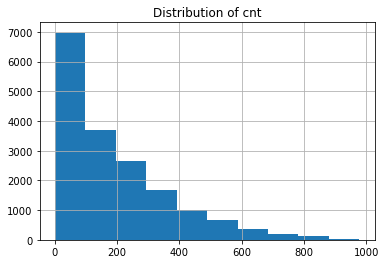

In [2]:
bike_rentals['cnt'].hist()
plt.title('Distribution of cnt')

According to the histogram, the cnt column is skewed to the right. About 40% of rental numbers are less than 100.

In [3]:
corr_coefficients = abs(bike_rentals.corr()['cnt'])
corr_coefficients[corr_coefficients>0.3].sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
Name: cnt, dtype: float64

Excluding registered and casual columns, since cnt is the sum of these, the following columns have high correlation with the cnt column:
- **temperature**
- **hour**
- **humidity**

## Adding a time_label feature
The hr column contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently without understanding that certain hours are related.  We can introduce some order into the process by creating a new column with labels for **morning**, **afternoon**, **evening**, and **night**. This will bundle similar times together, enabling the model to make better decisions.

We add the **time_label** column to the dataset that contains some numbers representing morning, afternoon, evening, and night:
- **1** if the hour is from **6 to 12**
- **2** if the hour is from **12 to 18**
- **3** if the hour is from **18 to 24**
- **4** if the hour is from **0 to 6**

In [4]:
def assign_laber(hour):
    if 6<= hour <12:
        return 1
    elif 12<= hour <18:
        return 2
    elif 18<= hour <24:
        return 3
    else:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_laber)
bike_rentals['time_label'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

In [5]:
corr_coefficients = abs(bike_rentals.corr()['cnt'])
corr_coefficients[corr_coefficients>0.3].sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
time_label    0.378318
hum           0.322911
Name: cnt, dtype: float64

The time_label column is also included in the correlated columns with cnt.

## Train and Test datasets
We select 80% of the rows in bike_rentals to be part of the training set and the rest to the testing set.

In [6]:
train = bike_rentals.sample(frac = .8, random_state = 1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (13903, 18)
test shape:  (3476, 18)


Since the cnt column contains continuous values, we use Linear Regression, Decision Tree Regression, and Random Forest for the modelling.

We also use the following metrics to evaluate the performance of the machine learning algorithms:
- Root of the mean square (RMSE): Gives us an absolute number on how much our predicted results deviate from the actual number. We apply each model to both the training dataset and the test dataset and calculate RMSE for both (called training error and validation error).
- R Squared (R2): Indicates how much of the variance the model accounts for. It is a good measure to determine how well the model fits the dependent variables. It is a value between 0 and 1 with a higher value preferred but if the value is too high value, this could indicate a sign of overfitting.
- Difference between training error and validation error: To prevent overfitting we minimize the difference between these two errors while minimizing the errors and looking for a high enough R Squared.

## Feature selection
First, we create a list of predictor columns to use in the training and predictions.

<AxesSubplot:>

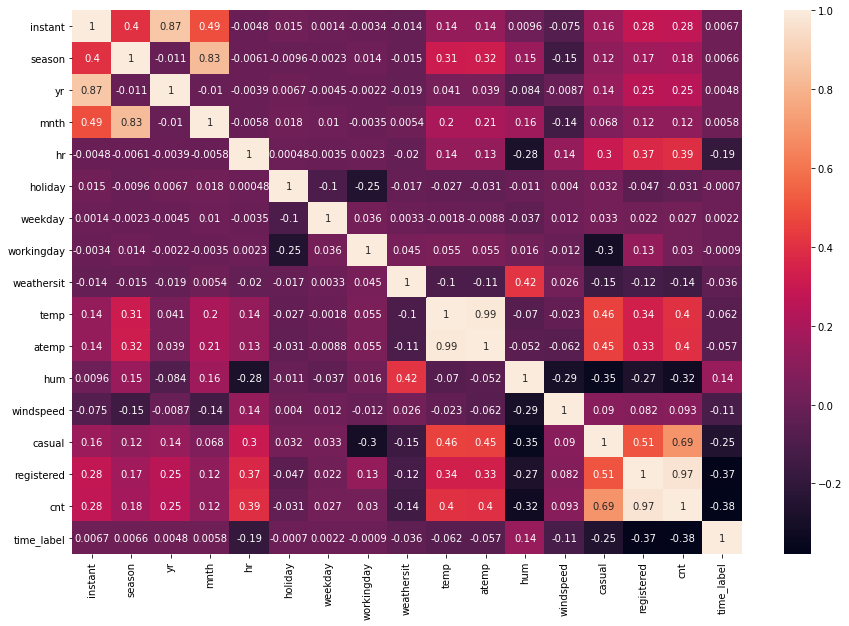

In [7]:
plt.figure(figsize=(15, 10))
sns.heatmap(bike_rentals.corr(), annot=True)

To make the feature list, the following notes are considered:
- We ignore the **casual** and **registered** columns because cnt is derived from them. 
- Temp and atemp columns are highly correlated so one of them is sufficient for prediction. We exclude the **atemp** column. 
- **dteday** is also excluded since it is not numeric and it's data is mentioned in other columns.
- **instant** is removed since it is only an id.
- **cnt** is removed since it is the target column.

In [8]:
excluded_columns = ['cnt', 'casual', 'registered', 'atemp', 'dteday', 'instant']
features = bike_rentals.columns.drop(excluded_columns)
features

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

## Linear Regression

In [9]:
def linear_regression(train , test, features, target):
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[target], predictions)
    return rmse, r2

train_error = linear_regression(train, train, features, 'cnt')
test_error = linear_regression(train, test, features, 'cnt')
print("Linear Regression")
print("*************************")
print("train error (rmse, r2):", train_error)
print("validation error (rmse, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Linear Regression
*************************
train error (rmse, r2): (132.72098501239842, 0.46934752277845493)
validation error (rmse, r2): (130.73388901626132, 0.4609665470190937)
Difference:  -1.9870959961371


Both training and validation errors are high and the training error is higher than the validation error. So the model seems too poor for prediction and there is a probability of underfitting.

## Decision Tree Algorithm

In [10]:
def DecisionTreeRegressor_model(train, test, feature, target, min_samples_leaf = 1, max_depth = None):
    dtr = DecisionTreeRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    dtr.fit(train[features], train[target])
    predictions = dtr.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[target], predictions)
    return rmse, r2

train_error = DecisionTreeRegressor_model(train, train, features, 'cnt')
test_error = DecisionTreeRegressor_model(train, test, features, 'cnt')
print("Decision Tree Regression with default settings")
print("***********************************************")
print("train error (rsme, r2):", train_error)
print("validation error (rsme, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Decision Tree Regression with default settings
***********************************************
train error (rsme, r2): (0.5693317794626366, 0.9999902352336465)
validation error (rsme, r2): (60.847263933502596, 0.8832326385958219)
Difference:  60.27793215403996


The error is significantly less than the error of the linear regression algorithm. Low training error while validation error is significantly larger shows overfitting. Too high r2 for training (0.99) can also be another sign of overfitting. 

We can tune the model by **changing the min_samples_leaf**.

In [11]:
train_rmses = []
test_rmses = []
for i in range (2, 20, 1):
    train_error = DecisionTreeRegressor_model(train, train, features, 'cnt', i)
    test_error = DecisionTreeRegressor_model(train, test, features, 'cnt', i)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])
print("Decision Tree Regression with changing min_samples_leaf")
print("***********************************************")
print("mean of train_rmses: ", np.mean(train_rmses))
print("mean of test_rmses: ", np.mean(test_rmses))
print("Difference of means: ", np.mean(test_rmses) - np.mean(train_rmses))

Decision Tree Regression with changing min_samples_leaf
***********************************************
mean of train_rmses:  41.32057502980713
mean of test_rmses:  55.861448333168966
Difference of means:  14.540873303361835


The mean of validation error and the difference of errors are lower than the equivalent metrics of the decision tree with default settings.

Text(0.5, 1.0, 'Error of Decision Tree Regression with changing min_samples_leaf')

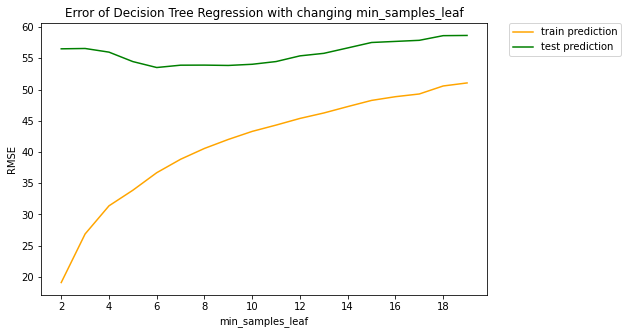

In [12]:
plt.figure(figsize=(8, 5))
x = range(2, 20, 1)
y1_dt_msl = train_rmses
plt.plot(x,y1_dt_msl, label = 'train prediction', color='orange')
y2_dt_msl = test_rmses
plt.plot(x,y2_dt_msl, label = 'test prediction', color='green')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=0)
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.title("Error of Decision Tree Regression with changing min_samples_leaf")

The validation error decreases from min_samples_leaf of 2 to 6. It almost stagnates for some min_samples_leaf and then increases again. The RMSE of the train set is lower than the RMSE of the test set and increases faster than the validation rate. 

The goal is to choose a min_samples_leaf with low errors and a low difference between errors. We choose 6 since it results in the lowest validation error.

In [13]:
train_error = DecisionTreeRegressor_model(train, train, features, 'cnt', 6)
test_error = DecisionTreeRegressor_model(train, test, features, 'cnt', 6)
print("Decision Tree Regression with min_samples_leaf = 6")
print("***********************************************")
print("train error (rsme, r2):", train_error)
print("validation error (rsme, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0]) 

Decision Tree Regression with min_samples_leaf = 6
***********************************************
train error (rsme, r2): (36.67688667014959, 0.9594756618899392)
validation error (rsme, r2): (53.52344548945019, 0.9096501401899009)
Difference:  16.846558819300597


Comparing with the decision tree with default settings, all the metrics have been improved:
- Lower validation error.
- Significantly lower difference between errors.
- More reasonable r2 but still high.

Generally, the algorithm is tuned to prevent overfitting but still shows some overfitting. We now keep min_samples_leaf = 6 and change the max_depth.

In [14]:
train_rmses = []
test_rmses = []
for i in range(2, 20, 1):
    train_error = DecisionTreeRegressor_model(train, train, features, 'cnt', 6, i)
    test_error = DecisionTreeRegressor_model(train, test, features, 'cnt', 6, i)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])
mean_train = np.mean(train_rmses)
mean_test = np.mean(test_rmses)
print("Decision Tree Regression with min_samples_leaf = 6 and changing max_depth")
print("***********************************************")
print("mean of train_mses: ", mean_train)
print("mean of test_mses: ", mean_test)
print("Difference of means: ", mean_test - mean_train)

Decision Tree Regression with min_samples_leaf = 6 and changing max_depth
***********************************************
mean of train_mses:  67.14661473045366
mean of test_mses:  75.84631786477163
Difference of means:  8.699703134317971


Text(0.5, 1.0, 'Error of Decision Tree Regression with changing max_depth')

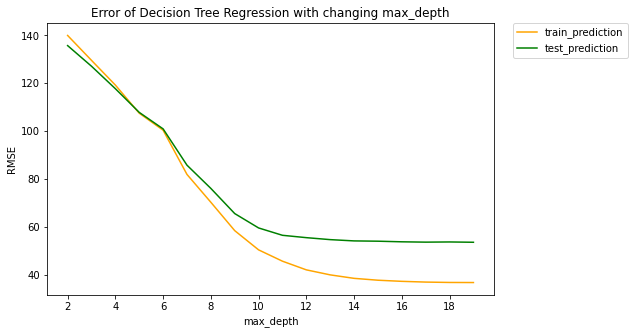

In [15]:
plt.figure(figsize=(8, 5))
x = range(2, 20, 1)
y1_dt_md = train_rmses
y2_dt_md = test_rmses
plt.plot(x,y1_dt_md, color='orange', label = 'train_prediction')
plt.plot(x,y2_dt_md, color='green', label = 'test_prediction')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=0)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.title("Error of Decision Tree Regression with changing max_depth")

According to the above plot, when max_depth is 6 the difference between validation and training errors is very low which is good, but the errors are high. When max_depth is 8, the errors are decreased significantly but the difference between errors does not increase too much. We can now compare the metrics more precisely when max_depth is 6 and 8.

In [16]:
train_error = DecisionTreeRegressor_model(train, train, features, 'cnt', 6, 6)
test_error = DecisionTreeRegressor_model(train, test, features, 'cnt', 6, 6)
print("Decision Tree Regression with min_samples_leaf = 6 and max_depth = 6")
print("***********************************************")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0]) 
print('\n')
train_error = DecisionTreeRegressor_model(train, train, features, 'cnt', 6, 8)
test_error = DecisionTreeRegressor_model(train, test, features, 'cnt', 6, 8)
print("Decision Tree Regression with min_samples_leaf = 6 and max_depth = 8")
print("***********************************************")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0]) 

Decision Tree Regression with min_samples_leaf = 6 and max_depth = 6
***********************************************
train error: (100.3688013042223, 0.6965211159548343)
validation error: (100.92225590683555, 0.6787721011210934)
Difference:  0.5534546026132432


Decision Tree Regression with min_samples_leaf = 6 and max_depth = 8
***********************************************
train error: (70.25102444467652, 0.8513255546152154)
validation error: (76.04017617681788, 0.8176416783640807)
Difference:  5.789151732141363


By Comparing these two results we choose max_depth = 8 because:
- Both errors are significantly lower.
- Both r squared are higher (but not too high).
- Although the difference between errors is higher, it is not too much.

Comparing this model with the decision tree with the same min_sample_leaf = 6 but with no limitation on max_depth, we can say that although the errors are higher, the difference between the errors is lower and the r2 values are more reasonable (0.85, 0.82) in comparison to (0.96, 0.91). So the model is generalized and fitted better than the previous one. 

## Random forest

In [17]:
def random_forest_model(train, test, feature, target, min_samples_leaf = 2, max_depth = None):
    rf = RandomForestRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    rf.fit(train[features], train[target])
    predictions = rf.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[target], predictions)
    return rmse, r2

train_error = random_forest_model(train, train, features, 'cnt')
test_error = random_forest_model(train, test, features, 'cnt')
print("random_forest_model with default setting")
print("***********************************************")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0]) 

random_forest_model with default setting
***********************************************
train error: (22.60038499483971, 0.9846126908900644)
validation error: (44.43433966320822, 0.9377302935087647)
Difference:  21.83395466836851


Training and validation errors are significantly lower but the difference between errors is higher. R squared seem too high as well. To fine tune the model we first change min_sample_leaf and then max_dept.

In [18]:
train_rmses = []
test_rmses = []
for i in range(2, 20, 1):
    train_error = random_forest_model(train, train, features, 'cnt', i, None)
    test_error = random_forest_model(train, test, features, 'cnt', i, None)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])
print("mean of train_mses: ", np.mean(train_rmses))
print("mean of test_mses: ", np.mean(test_rmses))
print("Difference of means: ", np.mean(test_rmses) - np.mean(train_rmses))

mean of train_mses:  40.83174867406686
mean of test_mses:  50.43206323166664
Difference of means:  9.60031455759978


Text(0.5, 1.0, 'Error comparison of Random Forest and Decision Tree with changing min_samples_leaf')

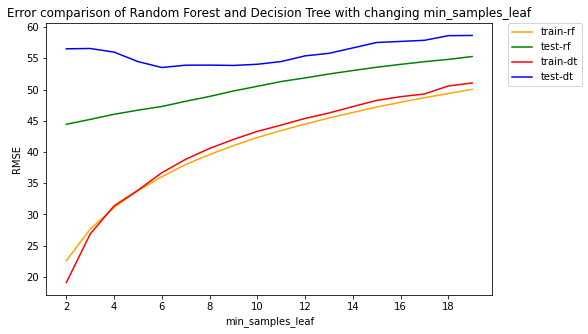

In [19]:
plt.figure(figsize=(8, 5))
x = range(2, 20, 1)
y1 = train_rmses
y2 = test_rmses
plt.plot(x,y1, color='orange', label = 'train-rf')
plt.plot(x,y2, color='green', label = 'test-rf')
plt.plot(x,y1_dt_msl, color='red', label = 'train-dt')
plt.plot(x,y2_dt_msl, color='blue', label = 'test-dt')
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)
plt.title('Error comparison of Random Forest and Decision Tree with changing min_samples_leaf')

The above plot shows clearly that the random forest model gives lower validation errors than the decision tree. The difference between errors is also decreased for all min_samples_leaf so the random forest seems to be a better fit. We now choose min_samples_leaf = 6 and change max_depth to see if we can get better results.

Text(0.5, 1.0, 'Error Comparison of Random Forest and Decision Tree with changing max_depth')

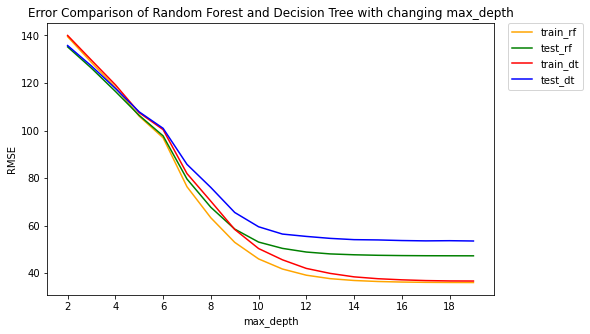

In [20]:
plt.figure(figsize=(8, 5))
train_rmses = []
test_rmses = []
for i in range(2, 20, 1):
    train_error = random_forest_model(train, train, features, 'cnt', 6, i)
    test_error = random_forest_model(train, test, features, 'cnt', 6, i)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])
x = range(2, 20, 1)
y1 = train_rmses
y2 = test_rmses
plt.plot(x,y1, color='orange', label = 'train_rf')
plt.plot(x,y2, color='green', label = 'test_rf')
plt.plot(x,y1_dt_md, color='red', label = 'train_dt')
plt.plot(x,y2_dt_md, color='blue', label = 'test_dt')

plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 2))
plt.title('Error Comparison of Random Forest and Decision Tree with changing max_depth')

The above plot shows random forest gives lower errors than the decision tree. We now can look at the result of the random forest when min_samples_leaf = 6 and max_depth = 8 and compare it with the decision tree with the same values.

In [21]:
train_error = random_forest_model(train, train, features, 'cnt', 6, 8)
test_error = random_forest_model(train, test, features, 'cnt', 6, 8)
print("random_forest_model with min_samples_leaf = 6 and max_depth = 8")
print("***********************************************")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0]) 

print("\n")

train_error = DecisionTreeRegressor_model(train, train, features, 'cnt', 6, 8)
test_error = DecisionTreeRegressor_model(train, test, features, 'cnt', 6, 8)
print("Decision Tree Regression with min_samples_leaf = 6 and max_depth = 8")
print("***********************************************")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0]) 

random_forest_model with min_samples_leaf = 6 and max_depth = 8
***********************************************
train error: (63.27842728715149, 0.8793736027362019)
validation error: (67.69771477968426, 0.8554602247104339)
Difference:  4.419287492532774


Decision Tree Regression with min_samples_leaf = 6 and max_depth = 8
***********************************************
train error: (70.25102444467652, 0.8513255546152154)
validation error: (76.04017617681788, 0.8176416783640807)
Difference:  5.789151732141363


Looking at the above metrics can result in the following understanding:
- All RMSEs are decreased in random forest.
- Difference of errors is lower in random forest.
- R squared is higher in the random forest but is not too high.

It seems the random forest algorithm with min_samples_leaf = 6 and max_depth = 8 is the best algorithm among the models we have tried to predict bike rentals.

## Conclusion

In [22]:
algorithms = pd.DataFrame(index = ['LR', 'DT Default', 'DT with min_samples_leaf = 6', 'DT with min_samples_leaf = 6 and max_depth = 8', 'RF Default', 'RF with min_samples_leaf = 6 and max_depth = 8'],
            columns = ['train_rsme', 'train_r2', 'test_rsme', 'test_r2', 'diff_rsme'], 
            data = np.array([[132.72, 0.47, 130.73, 0.46, -1.98],
                             [0.57, 0.99, 60.90, 0.88, 60.33],
                             [36.68, 0.96, 53.52, 0.91, 16.84],
                             [70.25, 0.85, 76.04, 0.82, 5.79],
                             [24.56, 0.98, 45.91, 0.93, 21.35],
                             [64.80, 0.87, 69.37, 0.85, 4.57]]))
algorithms
                          

,train_rsme,train_r2,test_rsme,test_r2,diff_rsme
LR,132.72,0.47,130.73,0.46,-1.98
DT Default,0.57,0.99,60.90,0.88,60.33
DT with min_samples_leaf = 6,36.68,0.96,53.52,0.91,16.84
DT with min_samples_leaf = 6 and max_depth = 8,70.25,0.85,76.04,0.82,5.79
RF Default,24.56,0.98,45.91,0.93,21.35
RF with min_samples_leaf = 6 and max_depth = 8,64.80,0.87,69.37,0.85,4.57


Among the above models, **Random Forest with min_samples_leaf = 6 and max_depth = 8** has shown the best results. Although some other models show lower errors, they seem overfitted because of a too high r squared value and a higher training error than validation error. This result has been achieved by applying a trade-off between the following criteria:
- Lower RSME.
- Lower difference between training and validation errors to prevent overfitting.
- High R squared but not too high to find a fitted algorithm that is not overfitted.